# Import Dataset

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# statistics
from scipy.stats import normaltest

# train test split
from sklearn.model_selection import train_test_split

# menyatukan beberapa tahap preprocessing atau fungsi lainnya
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# encoder dan scaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# algoritma ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

# cross validation untuk menentukan algoritma terbaik
from sklearn.model_selection import cross_val_score, StratifiedKFold

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# metrics untuk klasifikasi
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [40]:
df = pd.read_csv('/Users/aisthaia/Documents/DSW Project/telco_data_clustered.csv')

In [41]:
df.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Cluster Label
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,0
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,3
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,3
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0,1


In [42]:
df['Churn Label'].value_counts()

No     5174
Yes    1869
Name: Churn Label, dtype: int64

In [44]:
df['Churn Label'].value_counts()[0]/len(df)

0.7346301292063041

In [45]:
df['Churn Label'].value_counts()[1]/len(df)

0.2653698707936959

In [5]:
df = df[['Tenure Months', 'Location', 'Device Class', 'Cluster Label']]

In [6]:
df

,Tenure Months,Location,Device Class,Cluster Label
0,2,Jakarta,Mid End,0
1,2,Jakarta,High End,3
2,8,Jakarta,High End,3
3,28,Jakarta,High End,3
4,49,Jakarta,High End,1
...,...,...,...,...
7038,72,Jakarta,Low End,2
7039,24,Jakarta,Mid End,1
7040,72,Jakarta,High End,1
7041,11,Jakarta,Mid End,0


# Data Preprocessing

In [7]:
categorical_features = df.describe(include='object').columns

In [8]:
# menampilkan jumlah unik dan unique values untuk setiap kolom
pd.set_option('display.max_colwidth', None)
# data unik di tiap kolom
listItem = []
for col in categorical_features :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,Location,2,"[Bandung, Jakarta]"
1,Device Class,3,"[High End, Low End, Mid End]"


In [9]:
ordinal_mapping = [
    {'col':'Device Class', 'mapping':{'High End':3, 'Mid End':2, 'Low End':1}} 
] 

In [10]:
from sklearn.preprocessing import KBinsDiscretizer

transformer1 = ColumnTransformer([
    ('ordinal', OrdinalEncoder(cols=['Device Class'], mapping=ordinal_mapping), ['Device Class']),
    ('onehot', OneHotEncoder(drop='first'), ['Location']),
    ('discretizer', KBinsDiscretizer(n_bins=5, strategy='uniform', encode='onehot'), ['Tenure Months'])
], remainder='passthrough')

In [11]:
transformer1

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(cols=['Device Class'],
                                                mapping=[{'col': 'Device Class',
                                                          'data_type': dtype('O'),
                                                          'mapping': High End    3
Mid End     2
Low End     1
dtype: int64}]),
                                 ['Device Class']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['Location']),
                                ('discretizer',
                                 KBinsDiscretizer(strategy='uniform'),
                                 ['Tenure Months'])])

In [12]:
# scaling features 
robust = RobustScaler()

# for tuning
standard = StandardScaler()
minmax = MinMaxScaler()

# Model Benchmark

In [13]:
# Features
X = df.drop(columns='Cluster Label')

# target
y = df['Cluster Label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,
    random_state=0,
    stratify=y
)

In [15]:
# Define the models
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
xgb = XGBClassifier()


In [20]:
# Pilihan model
models = [logreg, knn, tree, xgb]

list_mean = []
list_std = []
list_all_score = []

# Mencari model terbaik berdasarkan f1 score terbesar dan std terkecil
for algoritma in models :

    # Pipeline berisi 3 tahap, untuk diisi di pada estimator di cross val
    pipe_model = Pipeline([
        ('preprocess', transformer1),
        ('scaler', standard),
        ('model', algoritma)
    ])

    # cross validation
    skfold = StratifiedKFold(n_splits = 5)
    
    model_cv = cross_val_score(
        estimator=pipe_model,
        X = X_train,    
        y = y_train,
        cv = skfold,
        scoring = make_scorer(f1_score, average='weighted'),
        error_score='raise'
    )

    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())
    list_all_score.append(model_cv.round(4))

In [21]:
# Perbandingan performa antar model
pd.DataFrame({
    'model':models,
    'mean': list_mean,
    'std': list_std,
    'all_score' : list_all_score
})

,model,mean,std,all_score
0,LogisticRegression(solver='liblinear'),0.811559,0.010219,"[0.8286, 0.8088, 0.8087, 0.7972, 0.8146]"
1,KNeighborsClassifier(),0.790482,0.016054,"[0.7622, 0.8026, 0.7858, 0.7937, 0.8081]"
2,"DecisionTreeClassifier(max_depth=5, random_state=0)",0.814459,0.007614,"[0.8213, 0.8138, 0.8189, 0.8, 0.8182]"
3,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...)",0.814459,0.007614,"[0.8213, 0.8138, 0.8189, 0.8, 0.8182]"


# Hyperparameter Tuning

In [22]:
# Hyperparameter untuk Decision Tree
hyperparam_space = {
    'model__max_depth':[2,3,4,5,6,7],                    
    'model__min_samples_split':[2,5,10,15,20,50,100],    
    'model__min_samples_leaf':[2,5,10,15,20,50,100]
}                                                        

# Pipeline
pipe_model = Pipeline([
    ('preprocess', transformer1),
    ('scaler', standard),
    ('model', tree)                  # benchmark model terpilih
])

# Define Grid Search
skfold = StratifiedKFold(n_splits = 5)

grid_search = GridSearchCV(
    estimator=pipe_model,           # model  
    param_grid=hyperparam_space,    # hyperparameter yang mau dituning
    cv=skfold,                      # jumlah fold (StratifiedKFold(n = 5))
    scoring='accuracy',                   # metrics
    n_jobs=-1                       # pakai semua processor
)

In [23]:
# fitting 
grid_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable sub

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(cols=['Device '
                                                                                              'Class'],
                                                                                        mapping=[{'col': 'Device '
                                                                                                         'Class',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': High End    3
Mid End     2
Low End     1
dtype: int64}]),
                                                                         ['Device '
                                                                          'Class']),
                                                                        ('onehot...
                                                                         ['Location']),
                                                                        ('discretizer',
                                                                         KBinsDiscretizer(strategy='uniform'),
                                                                         ['Tenure '
                                                                          'Months'])])),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(max_depth=5,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 3, 4, 5, 6, 7],
                         'model__min_samples_leaf': [2, 5, 10, 15, 20, 50, 100],
                         'model__min_samples_split': [2, 5, 10, 15, 20, 50,
                                                      100]},
             scoring='accuracy')

In [24]:
# score f1 terbaik
grid_search.best_score_

0.8152129817444219

In [25]:
# hyperparameter terbaik
grid_search.best_params_

{'model__max_depth': 4,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2}

In [26]:
# model terbaik
grid_search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(cols=['Device '
                                                                       'Class'],
                                                                 mapping=[{'col': 'Device '
                                                                                  'Class',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': High End    3
Mid End     2
Low End     1
dtype: int64}]),
                                                  ['Device Class']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Location']),
                                                 ('discretizer',
                                                  KBinsDiscretizer(strategy='uniform'),
                                                  ['Tenure Months'])])),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=2,
                                        random_state=0))])

# Predict to Test Set


**Before Tuning - Decision Tree**

In [32]:
# model benchmark
tree = DecisionTreeClassifier(max_depth=5, random_state=0)

tree_pipeline = Pipeline([
    ('preprocess', transformer1),
    ('scaler', robust),
    ('model', tree)
])

# fitting
tree_pipeline.fit(X_train, y_train)

# predict
y_pred = tree_pipeline.predict(X_test)

# evaluate 
accuracy_score(y_test, y_pred)

0.8168480832938949

In [35]:
f1_score(y_test, y_pred, average='weighted')

0.816582202710845

**Before Tuning - XGBoost**

In [37]:
xg_pipeline = Pipeline([
    ('preprocess', transformer1),
    ('scaler', robust),
    ('model', xgb)
])

# fitting
xg_pipeline.fit(X_train, y_train)

# predict
y_pred_xg = xg_pipeline.predict(X_test)

# evaluate 
accuracy_score(y_test, y_pred_xg)

0.8168480832938949

In [38]:
f1_score(y_test, y_pred_xg, average='weighted')

0.816582202710845

**After Tuning (Grid Search)**

In [113]:
# menggunakan model terbaik hasil gridsearch
model_gs = grid_search.best_estimator_

# fitting
model_gs.fit(X_train, y_train)

# predict
y_pred = model_gs.predict(X_test)

# evaluate 
accuracy_score(y_test, y_pred)

0.8168480832938949

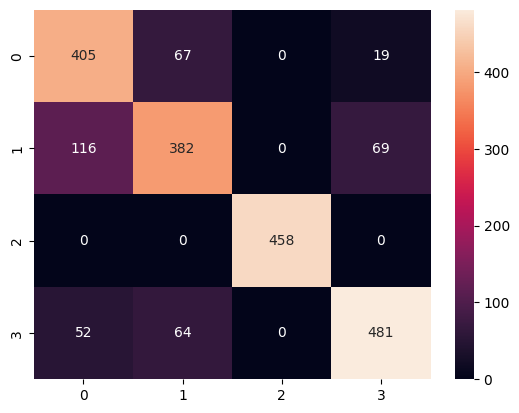

In [114]:
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');

# Save Model

In [122]:
import pickle

# Best Model
final_model = grid_search.best_estimator_

# Fitting to All Data
final_model.fit(X, y)

# Save
pickle.dump(final_model, open('rec_sys_telco.sav', 'wb'))

In [124]:
with open('/Users/aisthaia/Documents/DSW Project/rec_sys_telco.sav', 'rb') as model_file:
    classification_model = pickle.load(model_file)

In [134]:
user_data_features = df.loc[[7040]].drop(columns='Cluster Label')
user_data_features

,Tenure Months,Location,Device Class
7040,72,Jakarta,High End


In [136]:
classification_model.predict(user_data_features)[0]

1